=== UNSUPERVISED ANOMALY DETECTION: BREAST CANCER DATASET ===

[1/4] Data Loaded from UCI Repository.
Data Shape: (569, 30)
Anomaly Ratio: 37.26%

[2/4] Data Normalization Complete.

[3/4] Training Models (Contamination: 0.15)...
 -> Training KNN (K-Nearest Neighbors)...
 -> Training ABOD (Angle-Based Outlier Detection)...

EVALUATION RESULTS

--- KNN (K-Nearest Neighbors) ---
Silhouette Score: 0.3560
Confusion Matrix:
[[327  30]
 [161  51]]
Detected Malignancies (TP): 51 / 212
False Alarms (FP): 30

--- ABOD (Angle-Based Outlier Detection) ---
Silhouette Score: 0.2875
Confusion Matrix:
[[317  40]
 [147  65]]
Detected Malignancies (TP): 65 / 212
False Alarms (FP): 40

[4/4] Generating Visualizations...


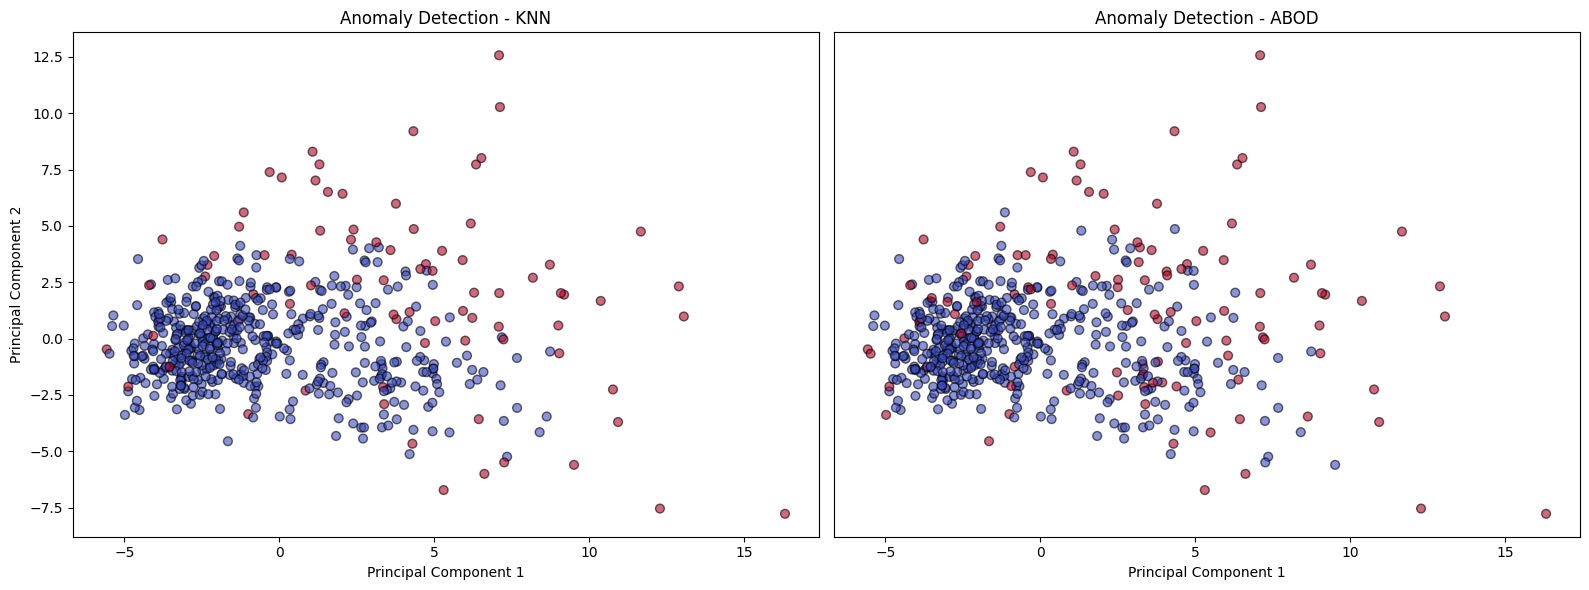

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix

# PyOD Imports
from pyod.models.knn import KNN
from pyod.models.abod import ABOD

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("=== UNSUPERVISED ANOMALY DETECTION: BREAST CANCER DATASET ===")

# 1. DATA LOADING & PREPARATION
# -----------------------------
# Define columns based on wdbc.names
column_names = ['ID', 'Diagnosis',
                'Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness', 'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dim',
                'SE Radius', 'SE Texture', 'SE Perimeter', 'SE Area', 'SE Smoothness', 'SE Compactness', 'SE Concavity', 'SE Concave Points', 'SE Symmetry', 'SE Fractal Dim',
                'Worst Radius', 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness', 'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 'Worst Symmetry', 'Worst Fractal Dim']

# Load dataset (assuming file is in current directory)
try:
    df = pd.read_csv('wdbc.data', header=None, names=column_names)
    print("\n[1/4] Data Loaded Successfully.")
except FileNotFoundError:
    # Fallback for online loading if local file is missing
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    df = pd.read_csv(url, header=None, names=column_names)
    print("\n[1/4] Data Loaded from UCI Repository.")

# Data Cleaning: Drop ID
df_clean = df.drop(columns=['ID'])

# Separate Features (X) and Labels (y)
# Note: PyOD is unsupervised, so 'y' is used ONLY for evaluation, not training.
X = df_clean.drop(columns=['Diagnosis'])
y_labels = df_clean['Diagnosis']

# Convert labels: Malignant (Anomaly) = 1, Benign (Normal) = 0
y_true = y_labels.apply(lambda x: 1 if x == 'M' else 0).values

print(f"Data Shape: {X.shape}")
print(f"Anomaly Ratio: {sum(y_true)/len(y_true):.2%}")

# 2. PREPROCESSING
# ----------------
# Normalization is crucial for distance-based algorithms like KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\n[2/4] Data Normalization Complete.")

# 3. MODEL TRAINING & EVALUATION
# ------------------------------
contamination = 0.15  # Estimated percentage of anomalies
print(f"\n[3/4] Training Models (Contamination: {contamination})...")

models = {
    'KNN (K-Nearest Neighbors)': KNN(contamination=contamination),
    'ABOD (Angle-Based Outlier Detection)': ABOD(contamination=contamination)
}

results = {}

for name, model in models.items():
    print(f" -> Training {name}...")
    model.fit(X_scaled)

    # Predict anomalies (0 = Normal, 1 = Anomaly)
    y_pred = model.predict(X_scaled)
    results[name] = y_pred

# 4. PERFORMANCE METRICS
# ----------------------
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

for name, y_pred in results.items():
    print(f"\n--- {name} ---")

    # Silhouette Score (Intrinsic Metric)
    sil = silhouette_score(X_scaled, y_pred)
    print(f"Silhouette Score: {sil:.4f}")

    # Confusion Matrix (Extrinsic Metric - vs Ground Truth)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    print(cm)
    print(f"Detected Malignancies (TP): {tp} / {tp+fn}")
    print(f"False Alarms (FP): {fp}")

# 5. VISUALIZATION (PCA)
# ----------------------
print("\n[4/4] Generating Visualizations...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(16, 6))

# Plot KNN
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=results['KNN (K-Nearest Neighbors)'], cmap='coolwarm', alpha=0.6, edgecolors='k', s=40)
plt.title('Anomaly Detection - KNN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot ABOD
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=results['ABOD (Angle-Based Outlier Detection)'], cmap='coolwarm', alpha=0.6, edgecolors='k', s=40)
plt.title('Anomaly Detection - ABOD')
plt.xlabel('Principal Component 1')
plt.yticks([])

plt.tight_layout()
plt.show()

### 📊 Evaluation Results

| Model | Silhouette Score | Detected Malignancies (TP) | False Positives (FP) |
| :--- | :---: | :---: | :---: |
| **KNN** (Distance-based) | 0.3560 | **51** / 212 | 30 |
| **ABOD** (Angle-based) | 0.2875 | **65** / 212 | 40 |

**Observations:**
* **ABOD** proved more sensitive, detecting **14 more malignant cases** than KNN.
* **KNN** provided better cluster separation (higher Silhouette Score) but missed more anomalies.
* The unsupervised approach successfully identified patterns corresponding to malignant tumors without using label data during training.